<a href="https://colab.research.google.com/github/erichsteinberg/NaturalLanguageCowboy/blob/main/QTM_340_FINAL_PROJECT_COMPUTER_COWBOY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##QTM 340-2 F24 FINAL PROJECT: COUNTRY LYRICS ANALYSIS
By Ari Gurovich, Eric Steinberg, Joshua Kim

**Research Objective:**
We employ multiple natural language processing methods to analyze a large dataset of country song lyrics, aiming to derive insights into their emotional tone, vocabulary richness, unique language, and recurring themes

Please note: some comments auto-generated through Gemini for your viewing ease


###Setup and creating our datasets

#### Importing packages

Install these upon new environment

In [ ]:
!pip install datasets
!pip install pyLDAvis
!pip install nrclex
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of nrclex to determine which version is comp

In [ ]:
# Core data science libraries
import pandas as pd
import numpy as np

# Text processing and NLP libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Topic modeling libraries
import gensim
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Machine learning libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Visualization libraries
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Utility libraries
import logging
from tqdm.notebook import tqdm
from datasets import load_dataset
import textwrap
import math
import itertools

#Sentiment analysis
from nrclex import NRCLex

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

/usr/local/lib/python3.10/dist-packages/textblob/_text.py:218: DeprecationWarning: invalid escape sequence '\.'
  RE_ABBR1 = re.compile("^[A-Za-z]\.$")       # single letter, "T. De Smedt"
/usr/local/lib/python3.10/dist-packages/textblob/_text.py:219: DeprecationWarning: invalid escape sequence '\.'
  RE_ABBR2 = re.compile("^([A-Za-z]\.)+$")    # alternating letters, "U.S."
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

#### Loading dataset and creating dataframes
This will take a while, also make sure you're connected to a powerful gpu. Only run ONCE, it will save a CSV which will be loaded for ease of use in future environments to prevent neededing to constantly reload/resample data from HF

In [ ]:
# Load the amishshah HF song lyricsdataset and save a random sample of 25% of the data.
sampled_songs = load_dataset("amishshah/song_lyrics", split="train").train_test_split(test_size=0.25, seed=30)['test']
df = pd.DataFrame(sampled_songs)

# Save to CSV
df.to_csv('song_lyrics_sample.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


song_lyrics_min.csv:   0%|          | 0.00/5.66G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
df = pd.read_csv('song_lyrics_sample.csv')

#Count the number of songs per genre
genre_counts = df['tag'].value_counts()
print("Number of Songs in Each Genre:")
print(genre_counts)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of Songs in Each Genre:
tag
pop        348547
rap        241143
rock       158148
rb          38608
misc        35398
country     21706
Name: count, dtype: int64


In [ ]:
#Create country_df by randomly sampling 20,000 country songs
country_df = df[df['tag'] == 'country'].sample(n=20000, random_state=42)

#Create non_country_df by randomly sampling 4,000 songs from pop, rap, rock, r&b, and misc
genres_to_sample = ['pop', 'rap', 'rock', 'rb', 'misc']
non_country_samples = [df[df['tag'] == genre].sample(n=4000, random_state=42) for genre in genres_to_sample]
non_country_df = pd.concat(non_country_samples, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


####Cleaning lyrics

In [ ]:
def clean_lyrics(lyrics):
    if pd.isna(lyrics):  # Handle NaN values
        return ""

    # Initialize tools
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Remove common song annotations
    lyrics = re.sub(r'\[.*?\]', '', lyrics)  # Remove [Verse], [Chorus], etc.
    lyrics = re.sub(r'\(.*?\)', '', lyrics)  # Remove (x2), (repeat), etc.

    # Remove specific filler words common in lyrics
    filler_words = {'yeah', 'oh', 'hey', 'ah', 'la', 'na', 'da', 'ooh', 'whoa'}
    stop_words.update(filler_words)

    # Preserve contractions that are meaningful in songs
    contractions_to_keep = {"ain't": "aint", "won't": "wont", "can't": "cant",
                           "don't": "dont", "i'm": "im", "i'll": "ill"}

    for contraction, replacement in contractions_to_keep.items():
        lyrics = lyrics.lower().replace(contraction, replacement)

    # Remove other special characters but preserve apostrophes initially
    lyrics = re.sub(r'[^a-zA-Z\'\s]', '', lyrics)

    # Split into words and process
    words = []
    for word in word_tokenize(lyrics):
        # Skip if it's a stop word or filler
        if word.lower() in stop_words:
            continue

        # Handle repeated letters (e.g., "loooove" -> "love")
        word = re.sub(r'(.)\1{2,}', r'\1', word)

        # Lemmatize only if not a preserved contraction
        if word not in contractions_to_keep.values():
            word = lemmatizer.lemmatize(word)

        words.append(word.lower())

    return ' '.join(words)

country_df['lyrics'] = country_df['lyrics'].apply(clean_lyrics)
non_country_df['lyrics'] = non_country_df['lyrics'].apply(clean_lyrics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Preview three songs from country and non country data
for df, genre_name in [(country_df, "Country"), (non_country_df, "Non-Country")]:
    print(f"Full lyrics for 3 random {genre_name} Songs:\n")
    for i in range(3):
        lyrics = df.sample(1)['lyrics'].values[0]
        print(f"{genre_name} Song {i+1}:\n{lyrics}\n{'-'*40}\n")

Full lyrics for 3 random Country Songs:

Country Song 1:
seems need better word fill gap fact say 've learned absolutely damn near every mother ive known miscarried lost baby time time seems need better word seems someone need say simple open obvious plain cause shame secret secret shame absolutely damn near every mother 've known miscarried lost baby held blame seems someone need say 's word dropped floor word 's something wrong seems body know 's right ancient meditation chemistry life thousand generation casting blessing disguise absolutely damn near every mother 've known lost baby felt carried light seems body know 's right 's word dropped floor 's word 's something wrong seems weve defied odds cause lie among living fly among god share themothers heartbeat pas mother 's blood absolutely every single time baby born chose know holiest form seems 've defied odds 's word dropped floor 's word something wrong seems need better word
----------------------------------------

Country Son

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###Method 1: Topic Modeling


#### Topic Modeling Main Method


In [ ]:
# Set logging level for gensim to suppress unnecessary output
logging.getLogger('gensim').setLevel(logging.ERROR)

# Define a set of stopwords specific to the domain
STOPWORDS = set(gensim.parsing.preprocessing.STOPWORDS) | {'verse', 'chorus', 'repeat', 'bridge'}

def analyze_lyrics(dataset, num_topics=12, output_file='./Lyrics_LDA_k_{num_topics}.html'):
    # Preprocess the dataset: tokenize, filter stopwords, and exclude very short/long tokens
    processed_docs = [
        [token for token in gensim.utils.simple_preprocess(text) if token not in STOPWORDS and 3 < len(token) < 20]
        for text in dataset
    ]

    # Create a dictionary mapping from words to unique IDs
    dictionary = Dictionary(processed_docs)
    # Filter out extremely rare and overly common tokens to improve model performance
    dictionary.filter_extremes(no_below=0.2, no_above=0.8)
    # Convert the tokenized documents into a bag-of-words format
    corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    # Ensure that the corpus is not empty after filtering
    if not corpus:
        raise ValueError("Corpus is empty after filtering.")

    # Train the LDA model with specified hyperparameters
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        alpha='auto',  # Automatically adjust topic distribution priors
        chunksize=1000,  # Number of documents to process at a time
        passes=15,  # Number of passes through the corpus
        iterations=300,  # Maximum iterations per pass
        eta=0.005,  # Topic-word distribution prior
        random_state=42  # Ensure reproducibility
    )

    # Calculate the coherence score to evaluate topic quality
    coherence_score = CoherenceModel(
        model=lda_model,
        texts=processed_docs,
        dictionary=dictionary,
        coherence='c_v'  # Measure based on a sliding window of words
    ).get_coherence()

    # Calculate the distribution of topics across the corpus
    topic_distributions = np.zeros(num_topics)
    for doc in corpus:
        for topic_id, prob in lda_model.get_document_topics(doc, minimum_probability=0.0):
            topic_distributions[topic_id] += prob
    # Normalize distributions by the number of documents
    topic_distributions /= len(corpus)

    # Prepare a visualization of the LDA topics and save as an HTML file
    vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
    pyLDAvis.save_html(vis_data, output_file.format(num_topics=num_topics))

    # Return analysis results including topics, coherence, and distributions
    return {
        'coherence_score': coherence_score,
        'topics': {idx: [(w, p) for w, p in topic if p > 0.01] for idx, topic in lda_model.show_topics(num_topics=-1, num_words=10, formatted=False)},
        'distributions': topic_distributions,
        'model': lda_model,
        'vis_data': vis_data
    }

def display_results(results):
    # Print the coherence score for the model
    print(f"Coherence Score: {results['coherence_score']:.3f}\n")
    # Display each topic with its top words and their probabilities
    for topic_id, words in results['topics'].items():
        print(f"Topic {topic_id + 1} (Distribution: {results['distributions'][topic_id]:.3f})")
        for word, prob in words:
            print(f"  {word:<15} {prob:.4f}")

if __name__ == "__main__":
    # Perform topic modeling on the dataset and display results
    results = analyze_lyrics(country_df['lyrics'].tolist())
    display_results(results)
    print("Analysis complete. Visualization saved.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score: 0.390

Topic 1 (Distribution: 0.164)
  like            0.0980
  dont            0.0750
  baby            0.0450
  little          0.0385
  good            0.0360
  aint            0.0338
  girl            0.0330
  want            0.0319
  right           0.0304
  know            0.0282
Topic 2 (Distribution: 0.041)
  light           0.0979
  night           0.0922
  shine           0.0350
  coming          0.0332
  star            0.0329
  christmas       0.0248
  burn            0.0221
  bright          0.0169
  waiting         0.0162
  bell            0.0144
Topic 3 (Distribution: 0.050)
  long            0.1166
  gone            0.0863
  song            0.0745
  sing            0.0429
  wrong           0.0396
  wish            0.0351
  play            0.0316
  miss            0.0294
  youre           0.0289
  lonely          0.0274
Topic 4 (Distribution: 0.066)
  lord            0.0454
  soul            0.0302
  heaven          0.0250
  river           0.0228
  wate

###Method 2: Log Odds

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 25 words most distinctive to country songs:
cowboy: 3.1391
tennessee: 3.0832
whiskey: 2.8287
ol: 2.7359
lonesome: 2.7187
truck: 2.4445
sittin: 2.2997
beer: 2.1995
heartache: 2.1984
guitar: 1.9195
livin: 1.9141
mornin: 1.8491
nothin: 1.7679
comin: 1.7655
porch: 1.7555
headed: 1.7079
gettin: 1.6807
daddy: 1.6199
friday: 1.5698
highway: 1.5507
waitin: 1.5402
mama: 1.5130
doin: 1.4875
boot: 1.4629
somethin: 1.3986

Top 25 words most distinctive to non-country songs:
gentleman: -2.3213
system: -2.3435
returned: -2.3676
mr: -2.3716
thou: -2.4355
force: -2.4790
account: -2.4792
form: -2.4959
enter: -2.5878
possible: -2.7065
also: -2.7112
several: -2.7212
indeed: -2.7677
experience: -2.8174
large: -2.8202
general: -2.8384
public: -2.9535
however: -2.9593
knowledge: -3.1140
effect: -3.1247
interest: -3.1361
manner: -3.4532
subject: -3.4803
thus: -3.7734
therefore: -4.6841


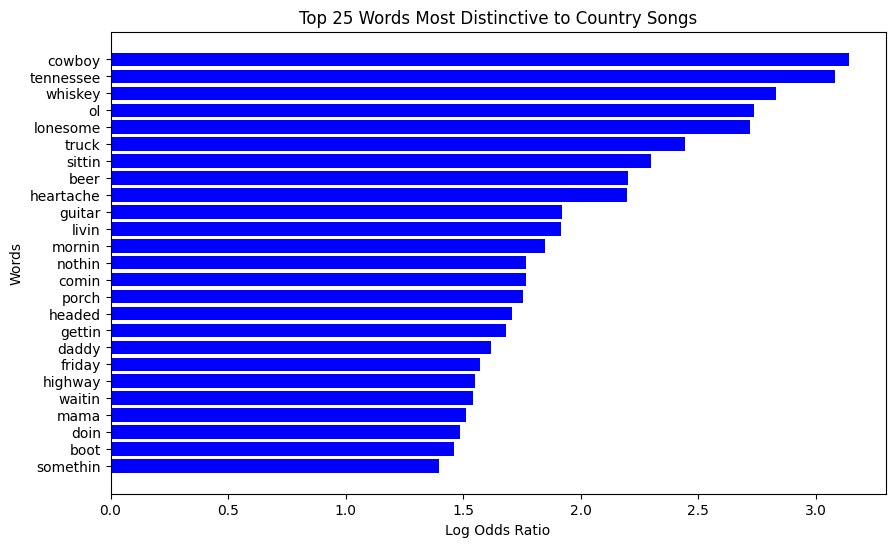

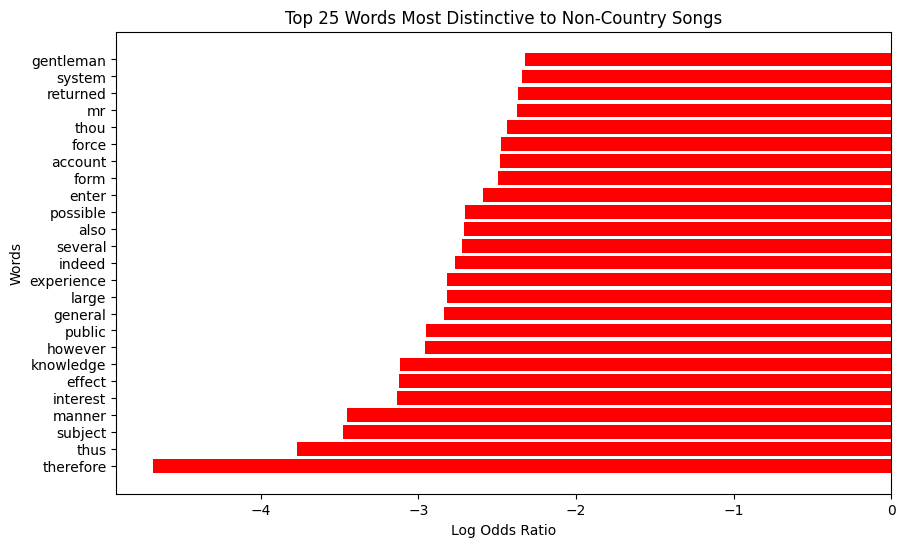

Log-odds analysis saved to 'log_odds_results.csv'.


In [ ]:

# Combine datasets and vectorize
dataset_combined = country_df['lyrics'].tolist() + non_country_df['lyrics'].tolist()
min_df = max(2, len(dataset_combined) // 100)
cv = CountVectorizer(min_df=min_df)
dtm_combined = cv.fit_transform(dataset_combined)

# Calculate word counts
feature_names = cv.get_feature_names_out()
country_counts = dtm_combined[:len(country_df), :].sum(axis=0).A1 + 1
non_country_counts = dtm_combined[len(country_df):, :].sum(axis=0).A1 + 1

# Calculate log-odds ratios
log_odds_ratios = np.log((country_counts / country_counts.sum()) / (non_country_counts / non_country_counts.sum()))
log_odds_sorted = sorted(zip(feature_names, log_odds_ratios), key=lambda x: x[1], reverse=True)

# Display results
print("Top 25 words most distinctive to country songs:")
for word, log_odds in log_odds_sorted[:25]:
    print(f"{word}: {log_odds:.4f}")

print("\nTop 25 words most distinctive to non-country songs:")
for word, log_odds in log_odds_sorted[-25:]:
    print(f"{word}: {log_odds:.4f}")

# Visualization
for label, words in zip(["Country", "Non-Country"], [log_odds_sorted[:25], log_odds_sorted[-25:]]):
    words, log_odds = zip(*words)
    plt.figure(figsize=(10, 6))
    plt.barh(words, log_odds, color='blue' if label == "Country" else 'red')
    plt.xlabel("Log Odds Ratio")
    plt.ylabel("Words")
    plt.title(f"Top 25 Words Most Distinctive to {label} Songs")
    plt.gca().invert_yaxis()
    plt.show()

# Save results
pd.DataFrame(log_odds_sorted, columns=["Word", "Log Odds Ratio"]).to_csv("log_odds_results.csv", index=False)
print("Log-odds analysis saved to 'log_odds_results.csv'.")

### Method 3: Vocabulary Richness

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mean Vocabulary Richness Metrics by Genre:
              ttr  hapax_legomena  avg_word_length
pop      0.551766        0.375204         4.737637
rap      0.590445        0.435096         4.630106
rb       0.494333        0.314448         4.556044
rock     0.602635        0.429460         4.893277
Country  0.551508        0.371937         4.621509


<ipython-input-10-2e63f18bbfca>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


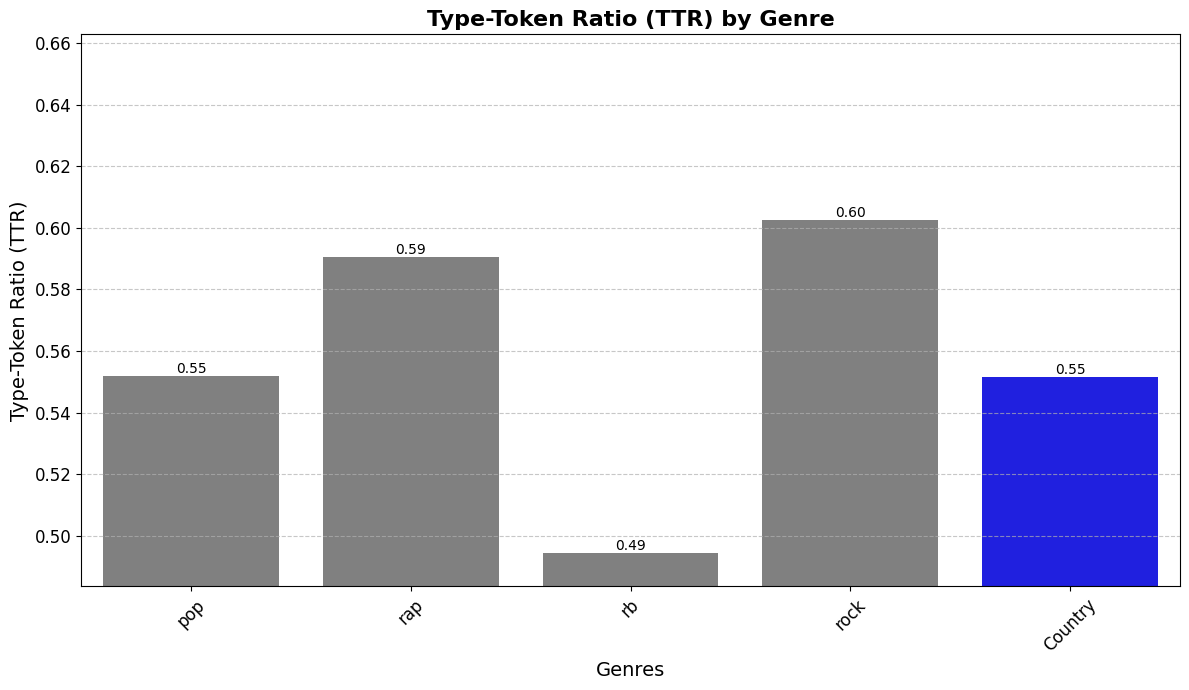

<ipython-input-10-2e63f18bbfca>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


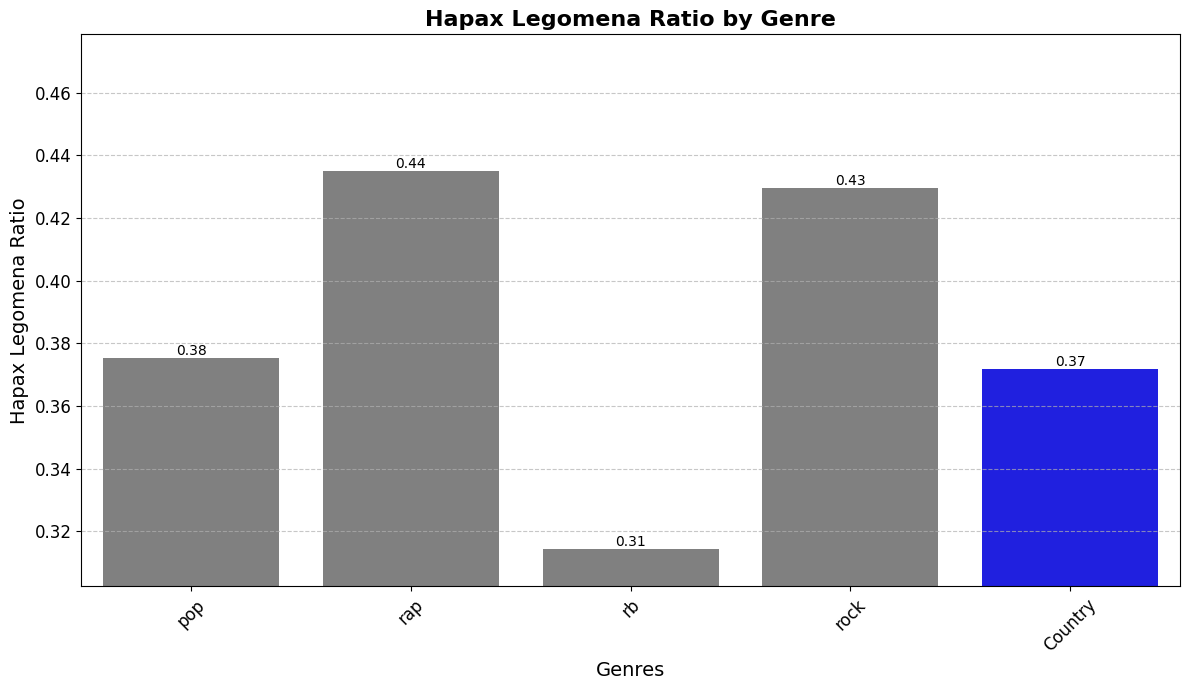

<ipython-input-10-2e63f18bbfca>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


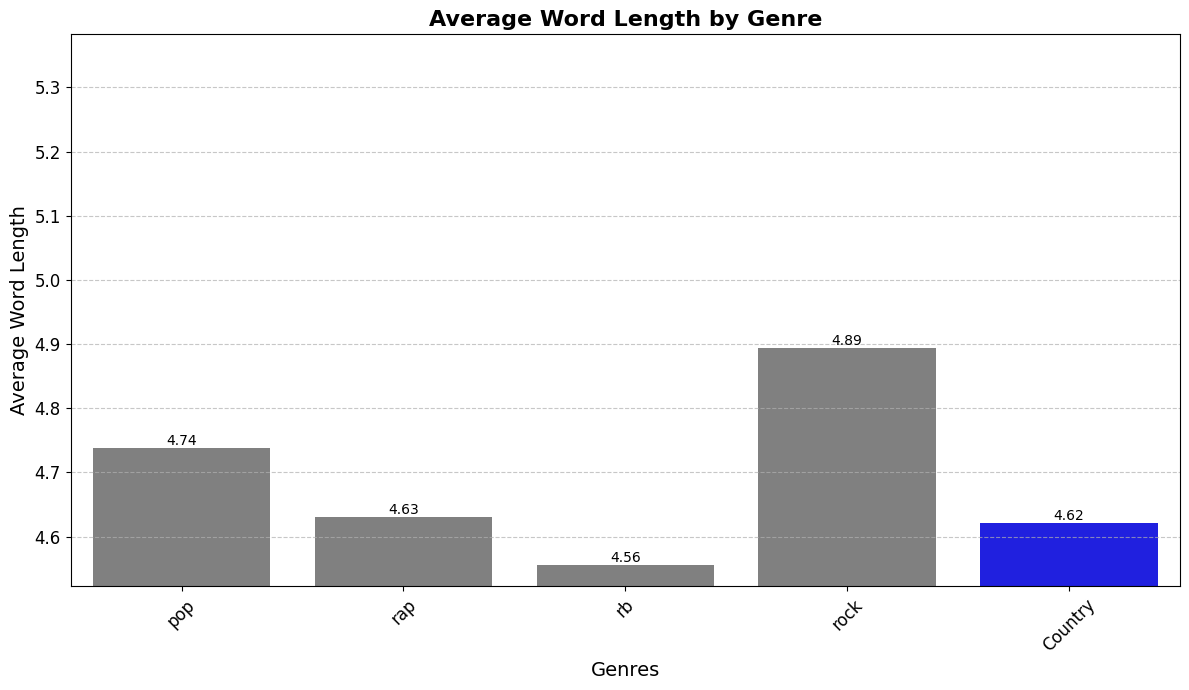

In [ ]:
import seaborn as sns

# Vocabulary Richness Measures
def calc_ttr(lyrics):
    """Calculate Type-Token Ratio (TTR)."""
    words = lyrics.split() if isinstance(lyrics, str) else []
    return len(set(words)) / len(words) if words else 0

def calc_hapax_legomena(lyrics):
    """Calculate Hapax Legomena Ratio."""
    words = lyrics.split() if isinstance(lyrics, str) else []
    word_counts = pd.Series(words).value_counts()
    return sum(word_counts == 1) / len(words) if words else 0

def calc_avg_word_length(lyrics):
    """Calculate Average Word Length."""
    words = lyrics.split() if isinstance(lyrics, str) else []
    return sum(len(word) for word in words) / len(words) if words else 0

# Apply Vocabulary Richness Metrics to Each Genre
def apply_vocabulary_metrics(df):
    for metric, func in zip(['ttr', 'hapax_legomena', 'avg_word_length'], [calc_ttr, calc_hapax_legomena, calc_avg_word_length]):
        df[metric] = df['lyrics'].apply(func)
    return df

# Apply metrics for country and non-country genres grouped by tag
country_df = apply_vocabulary_metrics(country_df)
non_country_df = apply_vocabulary_metrics(non_country_df)

# Group non-country songs by genre tag and calculate mean metrics
genre_means = non_country_df.groupby('tag')[['ttr', 'hapax_legomena', 'avg_word_length']].mean()

# Remove 'misc' genre from analysis
genre_means = genre_means.drop(index='misc', errors='ignore')

# Add country metrics to the comparison
country_means = country_df[['ttr', 'hapax_legomena', 'avg_word_length']].mean()
mean_values_df = pd.concat([genre_means, pd.DataFrame({'Country': country_means}).T])

# Display Mean Values
print("Mean Vocabulary Richness Metrics by Genre:")
print(mean_values_df)

# Visualization Bar Charts
for metric, metric_name in zip(['ttr', 'hapax_legomena', 'avg_word_length'], ['Type-Token Ratio (TTR)', 'Hapax Legomena Ratio', 'Average Word Length']):
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(
        x=mean_values_df.index,
        y=mean_values_df[metric],
        palette=["blue" if genre == "Country" else "gray" for genre in mean_values_df.index]
    )

    # Adjust y-axis scale to focus on differences
    min_value, max_value = mean_values_df[metric].min(), mean_values_df[metric].max()
    plt.ylim(min_value - (max_value - min_value) * 0.1, max_value * 1.1)

    plt.title(f'{metric_name} by Genre', fontsize=16, fontweight='bold')
    plt.xlabel('Genres', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), ".2f"),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
            textcoords='offset points'
        )

    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


### Method 4: Sentiment Analysis

In [ ]:
from nrclex import NRCLex
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# Function to calculate NRC sentiment scores for a DataFrame
def calculate_nrc_sentiment(df, text_column='lyrics'):
    def get_emotion_scores(text):
        analysis = NRCLex(text)
        return analysis.raw_emotion_scores

    sentiment_scores = df[text_column].apply(get_emotion_scores)
    return pd.DataFrame(list(sentiment_scores))

# Apply NRC sentiment analysis to country and non-country datasets
country_sentiments = calculate_nrc_sentiment(country_df)
non_country_sentiments = calculate_nrc_sentiment(non_country_df)

# Visualization 1: Distribution of emotion scores in country songs
plt.figure(figsize=(12, 8))
country_sentiments.mean().plot(kind='bar', alpha=0.7, color='blue')
plt.title('Average Emotion Scores for Country Songs')
plt.xlabel('Emotion')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization 2: Comparison of prominent emotions between country and each genre
genres = non_country_df['tag'].unique()
for genre in genres:
    genre_df = non_country_df[non_country_df['tag'] == genre]
    genre_sentiments = calculate_nrc_sentiment(genre_df)

    comparison = pd.DataFrame({
        'Country': country_sentiments.mean(),
        genre.capitalize(): genre_sentiments.mean()
    })

    plt.figure(figsize=(12, 8))
    comparison.plot(kind='bar', alpha=0.8)
    plt.title(f'Comparison of Emotion Scores: Country vs {genre.capitalize()}')
    plt.xlabel('Emotion')
    plt.ylabel('Average Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualization 3: Radar Chart of Emotion Scores for Country vs. Non-Country
categories = country_sentiments.columns
num_vars = len(categories)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Country data
country_values = country_sentiments.mean().tolist()
country_values += country_values[:1]
ax.plot(angles, country_values, linewidth=2, linestyle='solid', label='Country', color='blue')
ax.fill(angles, country_values, alpha=0.3, color='blue')

# Non-country data
non_country_values = non_country_sentiments.mean().tolist()
non_country_values += non_country_values[:1]
ax.plot(angles, non_country_values, linewidth=2, linestyle='dashed', label='Non-Country', color='red')
ax.fill(angles, non_country_values, alpha=0.3, color='red')

# Add labels and legend
plt.xticks(angles[:-1], categories, fontsize=10)
plt.title('Emotion Radar Chart: Country vs. Non-Country', size=15, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()
